In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sample as sm
from NotebookUtils.ProgressBar import LogProgress as LP
plt.rcParams['font.family']='serif' 
plt.rcParams['font.weight']='light'
plt.rcParams['font.size']=14
figsize = (16,8)
dataDir = '/Users/sdporzio/Data/'

glob = pd.read_json('Constants/constants.json')
c = glob['physics']['constants']['c']
m_lep = glob['physics']['mass']['mu']
g_f = glob['physics']['constants']['Gf']
detW = glob['experiment']['detector']['width']
detH = glob['experiment']['detector']['height']
detL = glob['experiment']['detector']['length']
detD = glob['experiment']['detector']['distance']
pipeL = glob['experiment']['decay_pipe']['length']
detD = detD - detL/2.
area = detH*detW
pi = np.pi
radius = np.sqrt(area/(2*pi))

In [61]:
def ThetaMax(l):
    '''
    Maximum angle with respect to the beam line that a neutrino
    can have in order to go through the detector.
    '''
    thetaMax = np.arccos( (detD-l) / np.sqrt((detD-l)**2 + (radius)**2) )
    return thetaMax

def ProjectionFunction(l,theta):
    '''
    Projection function. Returns 1 if neutrino trajectory is inside
    the detector. Return 0 otherwise.
    '''
    proj = np.where(theta <= ThetaMax(l), 1, 0)
    return proj

def Spectrum_Mes(p_spec,f_spec,p_mes,l,m_mes,m_lep,t_mes):
    '''
    Interpolated meson momentum spectrum as a function of position in the decay pipe.
    '''
    spec_mes = np.interp(p_mes,p_spec,f_spec,left=0.,right=0.)
    lambda_mes = (t_mes*c)*(p_mes/float(m_mes))
    spec_mes = spec_mes*np.exp(-1*np.divide(l,lambda_mes))
    return spec_mes

def E_Critical(m_mes,m_lep):
    '''
    Critical energy for neutrino kinematics.
    '''
    eCrit = (m_mes**2. - m_lep**2.)/float(2.*m_mes)
    return eCrit

def ThetaC(e_nu,m_mes,m_lep):
    '''
    Critical angle for neutrinos above critical energy.
    '''
    arg = (m_mes**2. - m_lep**2.)/float(2.*m_mes*e_nu)
    thetaC = np.arcsin(arg)
    return thetaC

def P_Mes(e_nu,theta,m_mes,m_lep,sign):
    '''
    Momentum of the meson given the angle and energy of the emitted neutrino
    Sign depends on whether the energy is above and below critical value.
    '''
    cosTheta = np.cos(theta)
    num1 = (m_mes**2. - m_lep**2.)*cosTheta
    num2 = np.sqrt((m_mes**2. - m_lep**2.)**2. - 4.*(1-(cosTheta)**2.)*m_mes**2. * e_nu**2.)
    den = 2.*(1-(cosTheta)**2.)*e_nu
    if sign>0:
        momentum = (num1+num2)/float(den)
    if sign<0:
        momentum = (num1-num2)/float(den)
    return momentum

def E_Mes(p_mes,m_mes):
    '''
    Energy of the meson given the mometum.
    '''
    energy = np.sqrt(p_mes**2 + m_mes**2)
    return energy
    
def MatrixElement2(m_mes,f_mes,v_mes):
    '''
    Matrix element for meson 2-body decay.
    '''
    matrixElement2 = 2*(g_f**2.)*(f_mes**2.)*(m_mes**4.)*(v_mes**2.)*((m_lep/float(m_mes))**2. - (m_lep/float(m_mes))**4.)
    return matrixElement2

def F_Term(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes,sign):
    '''
    Generic F term for the neutrino spectrum.
    '''
    p_mes = P_Mes(e_nu,theta,m_mes,m_lep,sign)
    e_mes = E_Mes(p_mes,m_mes)
    cosTheta = np.cos(theta)
    term1 = Spectrum_Mes(p_spec,f_spec,p_mes,l,m_mes,m_lep,t_mes)
    term2 = m_mes/float(p_mes)
    term3 = 1./float(2.*e_mes)
    term4 = 1./float(2.*np.absolute(cosTheta-(p_mes/float(e_mes))))
    result = term1*term2*term3*term4
    return result

def F_Low(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes):
    '''
    F term for neutrinos below critical energy.
    '''
    matEl = MatrixElement2(m_mes,f_mes,v_mes)
    fPlus = F_Term(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes,1)
    fLow = (matEl/float(8.*pi**2.))*fPlus
    return fLow
    
def F_High(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes):
    '''
    F term for neutrinos above critical energy.
    '''
    matEl = MatrixElement2(m_mes,f_mes,v_mes)
    fPlus = F_Term(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes,1)
    fMinus = F_Term(p_spec,f_spec,e_nu,theta,l,m_mes,f_mes,v_mes,-1)
    fHigh = (matEl/float(8.*pi**2.))*(fMinus+fPlus)
    return fHigh

In [83]:
# Settings
eBins = 200
lBins = 20
tBins = 20

inDir = dataDir+'HeavySterileNeutrinos/Bnb_MesonSpectrum/'
inData_k = pd.read_csv(inDir+'zmomentumSpectrum_K+.csv')
inData_pi = pd.read_csv(inDir+'zmomentumSpectrum_Pi+.csv')
spec_k = np.array([inData_k.zMomentum.values,inData_k.Spectrum.values])
spec_pi = np.array([inData_pi.zMomentum.values,inData_pi.Spectrum.values])

# Calculate Kaon
m_mes = glob['physics']['mass']['k+']
f_mes = glob['physics']['decay_const']['k+']
t_mes = glob['physics']['mean_life']['k+']
v_mes = glob['physics']['ckm']['us']

thetaMax = ThetaMax(50)
thetaLims = (0,thetaMax)
eRange = np.linspace(1,8000,eBins)
lengthRange = np.linspace(0,50,lBins)
cosThetaRange = np.linspace(np.cos(thetaLims[1]),np.cos(thetaLims[0]),tBins,endpoint=False)
critE = (m_mes**2. - m_lep**2.)/float(2.*m_mes)
flux_k = np.zeros(len(eRange))
for i,e_nu in enumerate(LP(eRange)):
    lInteg = 0
    for j,l in enumerate(lengthRange):
        tInteg = 0
        if e_nu<E_Critical(m_mes,m_lep):
            for k,cosTheta in enumerate(cosThetaRange):
                theta = np.arccos(cosTheta)
                fTerm = F_Low(spec_k[0],spec_k[1],e_nu,theta,l,m_mes,f_mes,v_mes)
                projTerm = ProjectionFunction(l,theta)
            lInteg += tInteg
        else:
            for k,cosTheta in enumerate(cosThetaRange):
                theta = np.arccos(cosTheta)
                fTerm = F_High(spec_k[0],spec_k[1],e_nu,theta,l,m_mes,f_mes,v_mes)
                projTerm = ProjectionFunction(l,theta)
                tInteg += fTerm*projTerm
            lInteg += tInteg           
    flux_k[i] = lInteg
    
# Calculate Pion
m_mes = glob['physics']['mass']['pi+']
f_mes = glob['physics']['decay_const']['pi+']
t_mes = glob['physics']['mean_life']['pi+']
v_mes = glob['physics']['ckm']['ud']


thetaMax = ThetaMax(50)
thetaLims = (0,thetaMax)
eRange = np.linspace(1,8000,eBins)
lengthRange = np.linspace(0,50,lBins)
cosThetaRange = np.linspace(np.cos(thetaLims[1]),np.cos(thetaLims[0]),tBins,endpoint=False)
critE = (m_mes**2. - m_lep**2.)/float(2.*m_mes)
flux_pi = np.zeros(len(eRange))
for i,e_nu in enumerate(LP(eRange)):
    lInteg = 0
    for j,l in enumerate(lengthRange):
        tInteg = 0
        if e_nu<E_Critical(m_mes,m_lep):
            for k,cosTheta in enumerate(cosThetaRange):
                theta = np.arccos(cosTheta)
                fTerm = F_Low(spec_pi[0],spec_pi[1],e_nu,theta,l,m_mes,f_mes,v_mes)
                projTerm = ProjectionFunction(l,theta)
                tInteg += fTerm*projTerm
            lInteg += tInteg
        else:
            for k,cosTheta in enumerate(cosThetaRange):
                theta = np.arccos(cosTheta)
                fTerm = F_High(spec_pi[0],spec_pi[1],e_nu,theta,l,m_mes,f_mes,v_mes)
                projTerm = ProjectionFunction(l,theta)
                tInteg += fTerm*projTerm
            lInteg += tInteg           
    flux_pi[i] = lInteg

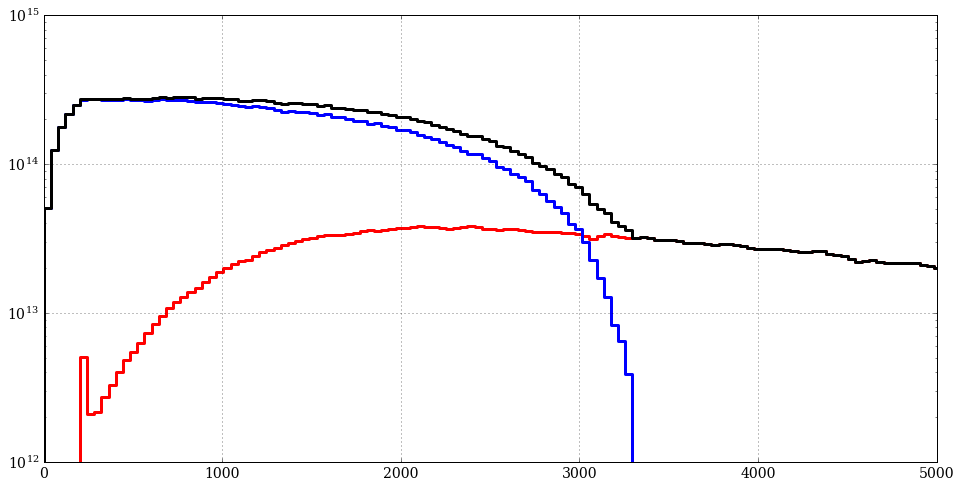

In [84]:
plt.figure(figsize=figsize)
plt.step(eRange,flux_k,color='red',lw=3)
plt.step(eRange,flux_pi,color='blue',lw=3)
plt.step(eRange,flux_k+flux_pi,color='black',lw=3)
plt.yscale('log')
plt.ylim(1e12,1e15)
plt.xlim(0,5000)
plt.grid()
plt.show()